In [1]:
from training_rl.offline_rl.custom_envs.custom_envs_registration import register_grid_envs
import warnings
from training_rl.offline_rl.load_env_variables import load_env_variables
from training_rl.offline_rl.custom_envs.utils import Grid2DInitialConfig
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import CustomEnv
from training_rl.offline_rl.scripts.visualizations.utils import snapshot_env
from training_rl.offline_rl.custom_envs.custom_envs_registration import RenderMode
from training_rl.offline_rl.custom_envs.utils import InitialConfigCustom2DGridEnvWrapper
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicyType
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset
from training_rl.offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from training_rl.offline_rl.scripts.visualizations.utils import get_state_action_data_and_policy_grid_distributions
from training_rl.offline_rl.utils import load_buffer_minari, state_action_histogram
from training_rl.offline_rl.offline_trainings.policy_config_data_class import TrainedPolicyConfig
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import offline_training
import torch
from training_rl.offline_rl.offline_trainings.policy_config_data_class import get_trained_policy_path
import os
from training_rl.offline_rl.offline_trainings.restore_policy_model import restore_trained_offline_policy


load_env_variables()
warnings.filterwarnings("ignore")
# ToDo: this should be load automatically
register_grid_envs()


/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`

### Exercise

**In this notebook we will deal with another importat property that we should fulfill with a robust offline RL algorithm, the stitching, i.e. the reuse of different trajectories contain in the data to obtain the best trajecroy in our dataset.**


The goal will be to reach a target at (7,7) starting from (0,0). We will use again the 8x8 grid environment. Our dataset contains trajectories covering our space of interest but generated for different tasks (note that before we collected data for the same task) . One is a suboptimal policy that moves the agent from (0,0) to (7,0) and the other is a deterministic an optimal one (human expert) that brings the agent from (4,0) to (7,7). We have obviously much more data coming from the suboptimal policy than the expert one as it is cheaper.

So we will create the two policies:

I  - **Suboptimal expert policy** (behavior_8x8_moves_downwards_within_strip):  moves agent in suboptimal way downwards starting from (0,0) (collect 8000 steps)

II - **Optimal expert poilcy**(behavior_8x8_deterministic_4_0_to_7_7): moves agent in the optimal path from (4,0) to (7,7) (collect 300 steps) 


In this example we will use again as off-policy RL algorithm, the Deep Q-Network (DQN) algorithm.

Let's setup our configuration and create the environment

### Environment

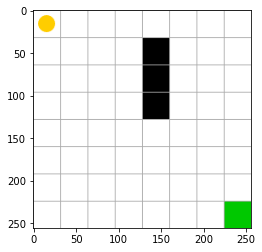

In [2]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

# Grid configuration
OBSTACLE = ObstacleTypes.verical_object_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (7, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), env_config=env_2D_grid_initial_config)
snapshot_env(env)

### Configure the two datasets

In [27]:
DATA_SET_IDENTIFIER_I = "_downwards_"
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip
NUM_STEPS_I = 30000

DATA_SET_IDENTIFIER_II = "_optimal_"
BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_deterministic_4_0_to_7_7
NUM_STEPS_II = 10000

### Create combined Minari dataset

In [28]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_colected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "_stiching",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)

Dataset Grid_2D_8x8_discrete-data_obst_free_8x8_start_0_0_target_7_7_downwards_-V0 deleted!
Dataset Grid_2D_8x8_discrete-data_obst_free_8x8_start_0_0_target_7_7_optimal_-V0 deleted!
Dataset Grid_2D_8x8_discrete-_stiching-V0 deleted!
Number of episodes in dataset I:500, in dataset I:715 and  in the combined dataset: 1215


### Rendering behavioral policy

In [29]:
# Suboptimal policy

offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY_I,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to tar

InterruptedError: You quit ('q') the animation.

In [30]:
# Expert policy
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY_II,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to target thread (0x563b25dcc940)

QObject::moveToThread: Current thread (0x563b25dcc940) is not the object's thread (0x563b25b9a720).
Cannot move to tar

### State-action distribution

Dataset /home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/examples/offline_RL_workshop/data/offline_data/Grid_2D_8x8_discrete-_stiching-V0 downloaded. number of episodes: 72


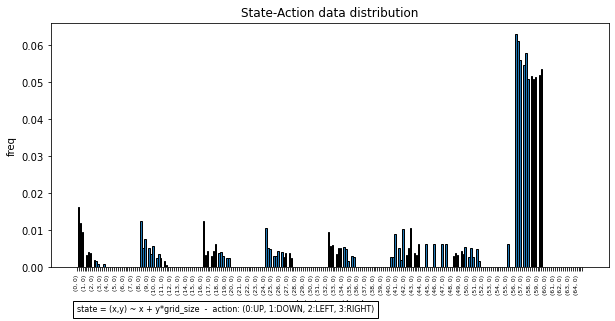

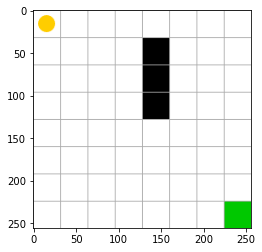

In [7]:
name_combined_dataset = config_combined_data.data_set_name

#Create Buffers with minari datasets
buffer_data = load_buffer_minari(name_combined_dataset)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution", inset_pos_xy=(-0.1, -0.012))

snapshot_env(env)

### Policy to train

In [23]:
POLICY_NAME = PolicyName.dqn

NAME_EXPERT_DATA = name_combined_dataset
# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=NAME_EXPERT_DATA,
    policy_name=POLICY_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    device="cpu"
)


### Training

In [ ]:
# Run the training

NUM_EPOCHS = 50
BATCH_SIZE = 256
UPDATE_PER_EPOCH = 100

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626


offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    update_per_epoch=UPDATE_PER_EPOCH,
    restore_training=False,
)

### Restore policy

In [31]:
POLICY_FILE = "policy_final.pth"

# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))


4 64


<All keys matched successfully>

### Let's visualize the policy

In [32]:
env_2D_grid_initial_config.obstacles = OBSTACLE.obst_free_8x8
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), env_config=env_2D_grid_initial_config)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

InterruptedError: You quit ('q') the animation.

Questions:

1 - Why do you notice? What happens if you increase the expert data? Is it better? 

2 - Try again with the BCQ algorithm.
